<a href="https://colab.research.google.com/github/wazeer23/Portfolio/blob/main/Amazon_Reviews_Sentiment_Analysis_Prediction_using_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Data

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Nov 24 23:47:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np 
import pandas as pd 

import bz2
import csv
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import os
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd


train = pd.read_csv('/content/drive/My Drive/training.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

#/content/drive/My Drive/test.ft.txt

In [ ]:
#combine to 1 dataframe
frames = [train, test]

In [ ]:
df = pd.concat(frames)

In [ ]:
df = df.reset_index()

In [ ]:
#since the dataframe is very large, i will only grab a select number of rows
#df = df.sample(frac=0.002, replace=True, random_state=42)
df = df.sample(frac=0.070, replace=True, random_state=42)


In [ ]:
df = df[['Sentence','Labels']]

In [ ]:
df

,Sentence,Labels
2219110,fantasy and science fiction; what's better!?: ...,1
2768307,a little too convenient: this was my first jo ...,1
2229084,too complex and not very fun: after 90 minutes...,0
3511566,darth vader still #1!: no way in the world can...,0
2356330,shoddy customer service: i can't review this p...,0
...,...,...
2327406,just a toy - can't be tuned: i have to disagre...,0
768159,couldn't get it to work well: be careful of th...,0
3750497,motorola hs850 bluetooth headset: i received a...,0
3500757,not good at all: i bought this on my recent tr...,0


Data Pre-processing

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each review.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 231118 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['Sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (280000, 250)


In [ ]:

Y = pd.get_dummies(df['Labels']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (280000, 2)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(224000, 250) (224000, 2)
(56000, 250) (56000, 2)


In [ ]:
Y_train

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]], dtype=uint8)

In [ ]:
df.Labels.value_counts()

1    140425
0    139575
Name: Labels, dtype: int64

Basic Embedding Model = Embedding + Flatten + Dense

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
flatten (Flatten)            (None, 25000)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 50002     
Total params: 5,050,002
Trainable params: 5,050,002
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
6720/6720 [==============================] - 216s 32ms/step - loss: 0.2847 - acc: 0.8833 - val_loss: 0.2527 - val_acc: 0.9015
Epoch 2/5
6720/6720 [==============================] - 216s 32ms/step - loss: 0.1369 - acc: 0.9514 - val_loss: 0.2922 - val_acc: 0.8938
Epoch 3/5
6720/6720 [==============================] - 216s 32ms/step - loss: 0.0384 - acc: 0.9895 - val_loss: 0.3884 - val_acc: 0.8888
Epoch 4/5
6720/6720 [==============================] - 216s 32ms/step - loss: 0.0100 - acc: 0.9979 - val_loss: 0.4946 - val_acc: 0.8830
Epoch 5/5
6720/6720 [==============================] - 213s 32ms/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.5694 - val_acc: 0.8839


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


1750/1750 [==============================] - 4s 2ms/step - loss: 0.5888 - acc: 0.8836
Test set
  Loss: 0.589
  Accuracy: 0.884


In [ ]:
import matplotlib.pyplot as plt

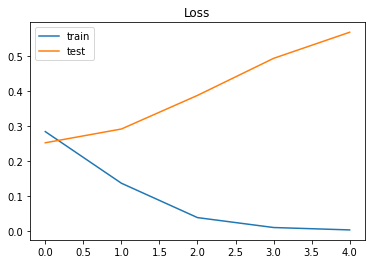

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

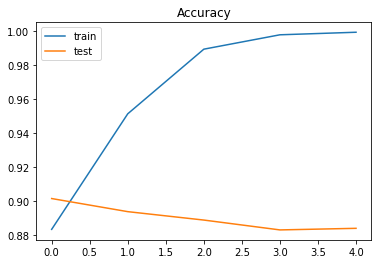

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [ ]:
y_pred = model.predict(X_test)


print('Basic Embedding AUC score:', roc_auc_score(Y_test, y_pred))

Basic Embedding AUC score: 0.9489982764982299


In [ ]:
first_model_score = roc_auc_score(Y_test, y_pred)

In [ ]:
first_model_score

0.9489982764982299

In [ ]:
test_pred =  model.predict(X_test)

In [ ]:
import numpy as np
rounded_test=np.argmax(Y_test, axis=1)
rounded_test[1]

1

In [ ]:
import numpy as np
rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]

1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0.5, 1.0, 'Basic Embedding')

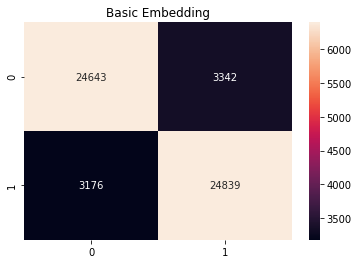

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
import seaborn as sns
import matplotlib.pyplot as plt
#labels = ['Negative','Positive']
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('Basic Embedding')

Adding Spatial 1D Dropout  

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 50002     
Total params: 5,050,002
Trainable params: 5,050,002
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
6720/6720 [==============================] - 215s 32ms/step - loss: 0.2880 - acc: 0.8810 - val_loss: 0.2486 - val_acc: 0.9044
Epoch 2/5
6720/6720 [==============================] - 214s 32ms/step - loss: 0.1495 - acc: 0.9457 - val_loss: 0.2916 - val_acc: 0.8929
Epoch 3/5
6720/6720 [==============================] - 217s 32ms/step - loss: 0.0564 - acc: 0.9825 - val_loss: 0.3423 - val_acc: 0.8930
Epoch 4/5
6720/6720 [==============================] - 214s 32ms/step - loss: 0.0230 - acc: 0.9934 - val_loss: 0.4283 - val_acc: 0.8870
Epoch 5/5
6720/6720 [==============================] - 216s 32ms/step - loss: 0.0110 - acc: 0.9971 - val_loss: 0.4905 - val_acc: 0.8879


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))



1750/1750 [==============================] - 4s 3ms/step - loss: 0.5060 - acc: 0.8855
Test set
  Loss: 0.506
  Accuracy: 0.886


In [ ]:

y_pred = model.predict(X_test)


print('Basic Embedding + Spatial Dropout AUC score:', roc_auc_score(Y_test, y_pred))


Basic Embedding + Spatial Dropout AUC score: 0.9515106723085476


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 1.0, 'Basic Embedding + Spacial Dropout Classification Report')

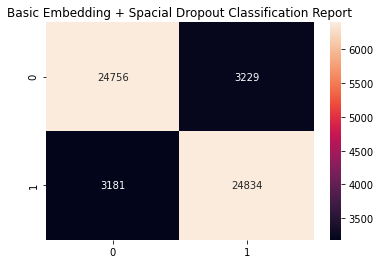

In [ ]:

test_pred =  model.predict(X_test)

rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('Basic Embedding + Spacial Dropout Classification Report')

In [ ]:
#Roc score

LSTM

In [ ]:
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
6720/6720 [==============================] - 2530s 377ms/step - loss: 0.2560 - accuracy: 0.8975 - val_loss: 0.1898 - val_accuracy: 0.9280
Epoch 2/5
6720/6720 [==============================] - 2571s 383ms/step - loss: 0.1614 - accuracy: 0.9397 - val_loss: 0.1739 - val_accuracy: 0.9354
Epoch 3/5
6720/6720 [==============================] - 2608s 388ms/step - loss: 0.1205 - accuracy: 0.9563 - val_loss: 0.1793 - val_accuracy: 0.9343
Epoch 4/5
6720/6720 [==============================] - 2612s 389ms/step - loss: 0.0904 - accuracy: 0.9687 - val_loss: 0.1951 - val_accuracy: 0.9322
Epoch 5/5
6720/6720 [==============================] - 2610s 388ms/step - loss: 0.0683 - accuracy: 0.9768 - val_loss: 0.2266 - val_accuracy: 0.9306


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


1750/1750 [==============================] - 115s 66ms/step - loss: 0.2302 - accuracy: 0.9292
Test set
  Loss: 0.230
  Accuracy: 0.929


In [ ]:

y_pred = model.predict(X_test)


print('LSTM AUC score:', roc_auc_score(Y_test, y_pred))


LSTM AUC score: 0.9758491490000746


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0.5, 1.0, 'LSTM')

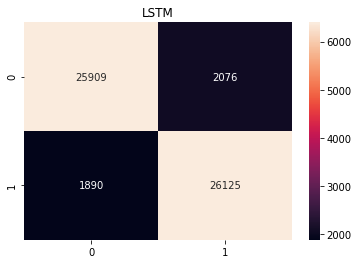

In [ ]:
test_pred =  model.predict(X_test)

rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('LSTM')

Bidirectional LSTM

In [ ]:
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model.add(SpatialDropout1D(0.2))
  model.add(Bidirectional(LSTM(100)))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 5,161,202
Trainable params: 5,161,202
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
6720/6720 [==============================] - 362s 54ms/step - loss: 0.2535 - accuracy: 0.8991 - val_loss: 0.1837 - val_accuracy: 0.9309
Epoch 2/5
6720/6720 [==============================] - 359s 53ms/step - loss: 0.1517 - accuracy: 0.9442 - val_loss: 0.1793 - val_accuracy: 0.9339
Epoch 3/5
  39/6720 [..............................] - ETA: 5:16 - loss: 0.1076 - accuracy: 0.9624

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))



In [ ]:

y_pred = model.predict(X_test)


print('Bi-Directional LSTM AUC score:', roc_auc_score(Y_test, y_pred))

In [ ]:

test_pred =  model.predict(X_test)

rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('Bi-Directional LSTM')

CNN

In [ ]:
num_kernels = 260
kernel_size = 3
hidden_dims = 300


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Dropout(0.2))
model.add(Conv1D(num_kernels,kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.5))
model.add(Dense(2, activation='relu'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print (model.summary())

In [ ]:

epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))



In [ ]:

y_pred = model.predict(X_test)


print('Basic CNN AUC score:', roc_auc_score(Y_test, y_pred))

In [ ]:

test_pred =  model.predict(X_test)

rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('1-D CNN')

GLovE Pre-Trained Model

In [ ]:
  
from numpy import array, asarray, zeros



In [ ]:
# load glove model
inMemoryGlove = dict()
f = open('/content/drive/My Drive/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefficients = asarray(values[1:], dtype='float32')
    inMemoryGlove[word] = coefficients
f.close()
print(len(inMemoryGlove))

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Sentence'].values)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % len(word_index))


In [ ]:

X = tokenizer.texts_to_sequences(df['Sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

encodeDocuments = X

In [ ]:

Y = pd.get_dummies(df['Labels']).values
print('Shape of label tensor:', Y.shape)


In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
# create coefficient matrix for training data
trainingToEmbeddings = zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    gloveVector = inMemoryGlove.get(word)
    if gloveVector is not None:
        trainingToEmbeddings[i] = gloveVector

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[trainingToEmbeddings], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences = True))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
#model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

In [ ]:
epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

In [ ]:

y_pred = model.predict(X_test)


print('GloVe Model AUC Score:', roc_auc_score(Y_test, y_pred))

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [ ]:

test_pred =  model.predict(X_test)

rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('GlovE')

BERT

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
    
    return np.array(all_tokens)

In [ ]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
model = build_model(transformer_layer, max_len=250)
model.summary()

In [ ]:
X = df['Sentence']

Y = df['Labels']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
train_input = bert_encode(X_train.values, tokenizer, max_len=250)
test_input = bert_encode(X_test.values, tokenizer, max_len=250)
train_labels = Y_train.values

In [ ]:

epochs = 1
batch_size = 30

history = model.fit(train_input, train_labels, epochs=epochs, batch_size=batch_size,validation_split=0.1)

In [ ]:

test_pred = model.predict(test_input, verbose = 1)

y_pred = test_pred.round().astype(int)



In [ ]:
print('BERT AUC Score:', roc_auc_score(Y_test, y_pred))

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(Y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('BERT')

In [ ]:
%%time
transformer_layer = transformers.OpenAIGPTTokenizer.from_pretrained('openai-gpt')
tokenizer = transformers.OpenAIGPTTokenizer.from_pretrained('openai-gpt')

In [ ]:
model = build_model(transformer_layer, max_len=160)
model.summary()

In [ ]:
!jupyter nbconvert --to html test.ipynb

In [ ]:
import pandas as pd

In [ ]:
results = pd.read_csv('results.csv')

In [ ]:
results

In [ ]:
import seaborn as sns

In [ ]:
ax = sns.barplot(x="AUC Score", y="Architecture", data=results, dodge = False, palette="icefire")
ax.set(xlim=(0.73, 1))
ax.set_title('Model AUC Score Comparision')